In [1]:
import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms

import torch.nn.functional as f 
from torch.autograd import Variable
torch.backends.cudnn.deterministic = True
import pandas as pd
import numpy as np
import torch.utils.data as data_utils
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split
from sklearn import metrics
import random 
from matplotlib import pyplot as plt

from sklearn import decomposition
from sklearn import manifold
from scipy import stats

In [2]:
import sys
import utilities as ut

In [3]:
train_dataset, test_dataset = ut.load_files(dataset=1)
n = 5000#train_dataset.shape[0] 
epsilon = 0.1
input_size = train_dataset.shape[1]-1
hidden_size = 500
hidden_size2 = 500
num_classes = 2
num_epochs = 200
batch_size = 512
learning_rate = 0.001
learning_rate2 = 0.001
regularization = False
add_DR_based_data = True
train_dataset = train_dataset.sample(n)


Freq1_harmonics_rel_phase_0
Freq2_harmonics_rel_phase_0
Freq3_harmonics_rel_phase_0


In [4]:
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [5]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True

In [6]:
train_dataset, test_dataset = ut.delete_outliers(train_dataset, test_dataset)

(3893, 61)
(28625, 60)
(28625, 61)


In [7]:
train_dataset = ut.sort_columns(train_dataset)
test_dataset = ut.sort_columns(test_dataset)

In [8]:
test_dataset_pred = test_dataset.copy()
train_dataset_pred = train_dataset.copy()

In [9]:
samples = 5000
samples1 = samples*2
number_columns = train_dataset.shape[1]
option = 2


data_prior = pd.DataFrame(0, index=np.arange(1), columns=train_dataset.columns)

if add_DR_based_data:
    #option 1
    if option == 1:
        for i in range(samples1):
            new_data = pd.DataFrame(0, index=np.arange(1), columns=train_dataset.columns) 
            new_data.columns = train_dataset.columns
            new_data['PeriodLS']= (np.random.uniform(0.2-epsilon,1.0+epsilon))#-minimum_period)/(maximum_period-minimum_period)
            new_data['label'] = 'Noise'
            frames = [data_prior, new_data]
            data_prior = pd.concat(frames, ignore_index=True)
    
    if option==2:
        #option 2
        for i in range(samples):
            new_data = pd.DataFrame(0, index=np.arange(1), columns=train_dataset.columns) 
            new_data.columns = train_dataset.columns
            new_data['PeriodLS']=(np.random.uniform(0.2-epsilon,0.2))#-minimum_period)/(maximum_period-minimum_period)
            new_data['label'] = 'Noise'
            frames = [data_prior, new_data]
            data_prior = pd.concat(frames, ignore_index=True)


        for i in range(samples):    
            new_data = pd.DataFrame(0, index=np.arange(1), columns=train_dataset.columns) 
            new_data.columns = train_dataset.columns
            new_data['PeriodLS']=(np.random.uniform(1.0,1.0+epsilon))
            new_data['label'] = 'Noise'
            frames = [data_prior, new_data]
            data_prior = pd.concat(frames, ignore_index=True)

        
    #option 3
    if option==3:
        for i in range(samples):    
            new_data = pd.DataFrame(0, index=np.arange(1), columns=train_dataset.columns) #pd.DataFrame([train_dataset.sample(1000).mean()]).T
            new_data['PeriodLS']= 1.0
            new_data['label'] = 'Noise'
            frames = [data_prior, new_data]
            data_prior = pd.concat(frames, ignore_index=True)


        for i in range(samples):    
            new_data = pd.DataFrame(0, index=np.arange(1), columns=train_dataset.columns) 
            new_data.columns = train_dataset.columns
            new_data['PeriodLS']= 0.2
            new_data['label'] = 'Noise'
            frames = [data_prior, new_data]
            data_prior = pd.concat(frames, ignore_index=True)


In [10]:
train_dataset, val_dataset = train_test_split(train_dataset, test_size=0.1, random_state=42)

In [11]:
train_dataset_prior, val_dataset_prior = train_test_split(data_prior, test_size=0.1, random_state=42)

In [12]:
train_dataset_prior['label'] = train_dataset_prior['label'].str.replace('ClassA', '1')
train_dataset_prior['label'] = train_dataset_prior['label'].str.replace('ClassB', '0')
train_dataset_prior['label'] = train_dataset_prior['label'].str.replace('Noise', '0.5')

train_target_prior = torch.tensor(train_dataset_prior['label'].values.astype(np.float32))
train_prior = torch.tensor(train_dataset_prior.drop('label', axis = 1).values.astype(np.float32)) 
train_prior = f.normalize(train_prior)
train_tensor_prior = data_utils.TensorDataset(train_prior, train_target_prior) 
train_loader_prior = data_utils.DataLoader(dataset = train_tensor_prior, batch_size = batch_size)

/home/franciscoperez/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/franciscoperez/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/franciscoperez/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See 

In [13]:
val_dataset_prior['label'] = val_dataset_prior['label'].str.replace('ClassA', '1')
val_dataset_prior['label'] = val_dataset_prior['label'].str.replace('ClassB', '0')
val_dataset_prior['label'] = val_dataset_prior['label'].str.replace('Noise', '0.5')
val_target_prior = torch.tensor(val_dataset_prior['label'].values.astype(np.float32))
val_prior = torch.tensor(val_dataset_prior.drop('label', axis = 1).values.astype(np.float32)) 
val_prior = f.normalize(val_prior)
val_tensor_prior = data_utils.TensorDataset(val_prior, val_target_prior) 
val_loader_prior = data_utils.DataLoader(dataset = val_tensor_prior, batch_size = batch_size)

/home/franciscoperez/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/franciscoperez/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/franciscoperez/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See 

Cases using DR 1: Period $ \in [0.2,1.0]$ days

In [14]:
train_dataset['label'] = train_dataset['label'].str.replace('ClassA', '1')
train_dataset['label'] = train_dataset['label'].str.replace('ClassB', '0')
train_dataset['label'] = train_dataset['label'].str.replace('Noise', '0.5')
train_target = torch.tensor(train_dataset['label'].values.astype(np.float32))
train = torch.tensor(train_dataset.drop('label', axis = 1).values.astype(np.float32)) 
train = f.normalize(train)
train_tensor = data_utils.TensorDataset(train, train_target) 
train_loader = data_utils.DataLoader(dataset = train_tensor, batch_size = batch_size)

In [15]:
train_dataset_pred['label'] = train_dataset_pred['label'].str.replace('ClassA', '1')
train_dataset_pred['label'] = train_dataset_pred['label'].str.replace('ClassB', '0')
train_dataset_pred['label'] = train_dataset_pred['label'].str.replace('Noise', '0.5')
train_target_pred = torch.tensor(train_dataset_pred['label'].values.astype(np.float32))
train_pred = torch.tensor(train_dataset_pred.drop('label', axis = 1).values.astype(np.float32)) 
train_pred = f.normalize(train_pred)
train_tensor_pred = data_utils.TensorDataset(train_pred, train_target_pred) 
train_loader_pred = data_utils.DataLoader(dataset = train_tensor_pred, batch_size = batch_size)

In [16]:
val_dataset['label'] = val_dataset['label'].str.replace('ClassA', '1')
val_dataset['label'] = val_dataset['label'].str.replace('ClassB', '0')
val_dataset['label'] = val_dataset['label'].str.replace('Noise', '0.5')
val_target = torch.tensor(val_dataset['label'].values.astype(np.float32))
val = torch.tensor(val_dataset.drop('label', axis = 1).values.astype(np.float32)) 
val = f.normalize(val)
val_tensor = data_utils.TensorDataset(val, val_target) 
val_loader = data_utils.DataLoader(dataset = val_tensor, batch_size = batch_size)

In [17]:
test_dataset['label'] = test_dataset['label'].str.replace('ClassA', '1')
test_dataset['label'] = test_dataset['label'].str.replace('ClassB', '0')
test_dataset['label'] = test_dataset['label'].str.replace('Noise', '0.5')
test_target = torch.tensor(test_dataset['label'].values.astype(np.float32))
test = torch.tensor(test_dataset.drop('label', axis = 1).values.astype(np.float32)) 
test = f.normalize(test)
test_tensor = data_utils.TensorDataset(test, test_target) 
test_loader = data_utils.DataLoader(dataset = test_tensor, batch_size = batch_size)

In [18]:
test_dataset_pred['label'] = test_dataset_pred['label'].str.replace('ClassA', '1')
test_dataset_pred['label'] = test_dataset_pred['label'].str.replace('ClassB', '0')
test_dataset_pred['label'] = test_dataset_pred['label'].str.replace('Noise', '0.5')
test_target_pred = torch.tensor(test_dataset_pred['label'].values.astype(np.float32))
test_pred = torch.tensor(test_dataset_pred.drop('label', axis = 1).values.astype(np.float32)) 
test_pred = f.normalize(test_pred)
test_tensor_pred = data_utils.TensorDataset(test_pred, test_target_pred) 
test_loader_pred = data_utils.DataLoader(dataset = test_tensor_pred, batch_size = batch_size)

In [19]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size,hidden_size2, num_classes):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) 
        #self.relu = nn.ReLU()
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size2)  
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size2, num_classes) 
        #self.sigmoid = nn.Sigmoid()
        #self.dropout = nn.Dropout(p=0.1)
        #self.batchnorm1 = nn.BatchNorm1d(hidden_size)
        #self.batchnorm2 = nn.BatchNorm1d(hidden_size)
        
        
    def forward(self, x):
        out1 = self.fc1(x)
        #out = self.batchnorm1(out)
        #out = self.relu(out)
        out = self.relu(out1)
        out2 = self.fc2(out)
        #out = self.batchnorm1(out)
        out = self.relu2(out)
        out3 = self.fc3(out)
        #x = self.dropout(x)
        #out = self.sigmoid(out)
        return out3, out2, out1
  
#net_prior = Net(input_size, hidden_size, hidden_size2, num_classes)

#net_prior.cuda()

net = Net(input_size, hidden_size, hidden_size2, num_classes)

#use_cuda = torch.cuda.is_available()

net.cuda()
#net = nn.DataParallel(net)

Net(
  (fc1): Linear(in_features=60, out_features=500, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=500, out_features=500, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=500, out_features=2, bias=True)
)

In [20]:
param_l1 = list(net.fc1.parameters())
param_l2 = list(net.fc2.parameters())
param_l3 = list(net.fc3.parameters())
#print(len(param))
print(len(param_l1[0]))
print(len(param_l1[:][0]))
#print(len(param[1]))

500
500


In [21]:
# Loss and Optimizer
criterion = nn.CrossEntropyLoss()  
#criterion = nn.BCELoss()
#criterion = nn.BCEWithLogitsLoss()

optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)  
optimizer_prior = torch.optim.Adam(net.parameters(), lr=learning_rate)   

In [22]:
from itertools import cycle
aux_loss_activated = True
# Train the Model   
loss_prior = torch.tensor(0)
hist_train = []
hist_val = []
aux_loss_behaviour = []
num_epochs_prior = 2000


EPS = 1e-3
locked_masks = {n: torch.abs(w) < EPS for n, w in net.named_parameters() if n.endswith('weight')}

EPS = 1e-6
locked_masks2 = {n: torch.abs(w) < EPS for n, w in net.named_parameters() if n.endswith('weight')}


for epoch in range(num_epochs_prior):
    epoch_loss = 0.0
    running_loss = 0.0
    epoch_loss_prior = 0.0    
    running_loss_prior = 0.0
    
    for item1, item2 in zip(train_loader, cycle(train_loader_prior)):
        star_prior, labels_prior = item2
        star, labels = item1
        
        star = Variable(star.view(-1, input_size)).cuda()
        labels = Variable(labels).cuda()
        optimizer.zero_grad()  
        outputs, _, _ = net(star)
        loss = criterion(outputs, labels.long())      
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        if aux_loss_activated:
            star_prior = Variable(star_prior.view(-1, input_size)).cuda()
            labels_prior = Variable(labels_prior).cuda()
            optimizer_prior.zero_grad()  # zero the gradient buffer
            outputs_prior, _, _ = net(star_prior)
            #print("-------------------before----------------------")
            aux_loss_behaviour.append(loss_prior.item())
            loss_prior = criterion(outputs_prior, labels_prior.long()) #custom_loss_auxiliar(outputs_prior)      
            #print("-------------------later-----------------------")
            aux_loss_behaviour.append(loss_prior.item())
            loss_prior.backward()
            
            for n, w in net.named_parameters():                                                                                                                                                                           
                if w.grad is not None and n in locked_masks2:                                                                                                                                                                                   
                    w.grad[locked_masks2[n]] = 0 
                
                
            optimizer_prior.step()
            epoch_loss_prior += outputs_prior.shape[0] * loss_prior.item()      
            running_loss_prior += loss_prior.item()
        
    hist_train.append(running_loss/len(train_loader))    
    print('training:', 'epoch: ', str(epoch+1),' loss: ', str(running_loss/len(train_loader)))
    
    epoch_loss = 0.0
    running_loss = 0.0
    for i, (star, labels) in enumerate(val_loader):  
        
        star = Variable(star.view(-1, input_size)).cuda()
        labels = Variable(labels).cuda()
        optimizer.zero_grad()  
        outputs, _, _ = net(star)
        loss = criterion(outputs, labels.long())      
        loss.backward()
        
        for n, w in net.named_parameters():                                                                                                                                                                           
            if w.grad is not None and n in locked_masks:                                                                                                                                                                                   
                w.grad[locked_masks[n]] = 0 
        
        optimizer.step()
        running_loss += loss.item()
    
    print('validating:', 'epoch: ', str(epoch+1),' loss: ', str(running_loss / len(val_loader)))
    hist_val.append(running_loss / len(val_loader))

training: epoch:  1  loss:  0.6054309478827885
validating: epoch:  1  loss:  0.4727281928062439
training: epoch:  2  loss:  0.37345172677721294
validating: epoch:  2  loss:  0.3163779675960541
training: epoch:  3  loss:  0.26516878604888916
validating: epoch:  3  loss:  0.27965477108955383
training: epoch:  4  loss:  0.24998934141227178
validating: epoch:  4  loss:  0.2914126217365265
training: epoch:  5  loss:  0.25370958021708895
validating: epoch:  5  loss:  0.29038166999816895
training: epoch:  6  loss:  0.24615950456687383
validating: epoch:  6  loss:  0.27581191062927246
training: epoch:  7  loss:  0.23367616747106826
validating: epoch:  7  loss:  0.26042085886001587
training: epoch:  8  loss:  0.2235518821648189
validating: epoch:  8  loss:  0.2494979202747345
training: epoch:  9  loss:  0.21672880223819188
validating: epoch:  9  loss:  0.24247783422470093
training: epoch:  10  loss:  0.21148578183991568
validating: epoch:  10  loss:  0.23741762340068817
training: epoch:  11  lo

training: epoch:  84  loss:  0.07552868979317802
validating: epoch:  84  loss:  0.10083836317062378
training: epoch:  85  loss:  0.07485305198601314
validating: epoch:  85  loss:  0.10014114528894424
training: epoch:  86  loss:  0.0741769549037729
validating: epoch:  86  loss:  0.09947870671749115
training: epoch:  87  loss:  0.07352498493024281
validating: epoch:  87  loss:  0.09878133982419968
training: epoch:  88  loss:  0.07287525545273509
validating: epoch:  88  loss:  0.09813568741083145
training: epoch:  89  loss:  0.07224053623420852
validating: epoch:  89  loss:  0.09748027473688126
training: epoch:  90  loss:  0.07161510310002736
validating: epoch:  90  loss:  0.09682069718837738
training: epoch:  91  loss:  0.0710007372711386
validating: epoch:  91  loss:  0.09617343544960022
training: epoch:  92  loss:  0.07038961776665278
validating: epoch:  92  loss:  0.09549036622047424
training: epoch:  93  loss:  0.06978097451584679
validating: epoch:  93  loss:  0.09484703838825226
tr

training: epoch:  165  loss:  0.043569114591394155
validating: epoch:  165  loss:  0.06492390483617783
training: epoch:  166  loss:  0.04335343704691955
validating: epoch:  166  loss:  0.0646139606833458
training: epoch:  167  loss:  0.043140130915812085
validating: epoch:  167  loss:  0.06428472697734833
training: epoch:  168  loss:  0.0429326772157635
validating: epoch:  168  loss:  0.06397771835327148
training: epoch:  169  loss:  0.042721964684980254
validating: epoch:  169  loss:  0.06366357207298279
training: epoch:  170  loss:  0.04251853350017752
validating: epoch:  170  loss:  0.06334074586629868
training: epoch:  171  loss:  0.04231486575944083
validating: epoch:  171  loss:  0.06303074955940247
training: epoch:  172  loss:  0.04211388315473284
validating: epoch:  172  loss:  0.06274324655532837
training: epoch:  173  loss:  0.04191287500517709
validating: epoch:  173  loss:  0.06239955499768257
training: epoch:  174  loss:  0.04171750242156642
validating: epoch:  174  loss: 

training: epoch:  249  loss:  0.031140657673989023
validating: epoch:  249  loss:  0.04499313235282898
training: epoch:  250  loss:  0.03103911637195519
validating: epoch:  250  loss:  0.044791705906391144
training: epoch:  251  loss:  0.030944406720144407
validating: epoch:  251  loss:  0.04458543658256531
training: epoch:  252  loss:  0.03084064195198672
validating: epoch:  252  loss:  0.0444539375603199
training: epoch:  253  loss:  0.030740906883563315
validating: epoch:  253  loss:  0.04429304599761963
training: epoch:  254  loss:  0.03063798403101308
validating: epoch:  254  loss:  0.04415058717131615
training: epoch:  255  loss:  0.03053941604282175
validating: epoch:  255  loss:  0.04397604614496231
training: epoch:  256  loss:  0.030439251235553196
validating: epoch:  256  loss:  0.04383299499750137
training: epoch:  257  loss:  0.030342279002070427
validating: epoch:  257  loss:  0.043672285974025726
training: epoch:  258  loss:  0.030245878334556307
validating: epoch:  258  

training: epoch:  333  loss:  0.02409727738371917
validating: epoch:  333  loss:  0.03474106267094612
training: epoch:  334  loss:  0.0240275931677648
validating: epoch:  334  loss:  0.03464452177286148
training: epoch:  335  loss:  0.0239627869533641
validating: epoch:  335  loss:  0.03453578054904938
training: epoch:  336  loss:  0.023888583428093364
validating: epoch:  336  loss:  0.03446206822991371
training: epoch:  337  loss:  0.02382160084588187
validating: epoch:  337  loss:  0.03434908762574196
training: epoch:  338  loss:  0.02375245120908533
validating: epoch:  338  loss:  0.03426457941532135
training: epoch:  339  loss:  0.023683192474501475
validating: epoch:  339  loss:  0.03417377918958664
training: epoch:  340  loss:  0.023612442825521742
validating: epoch:  340  loss:  0.03410669043660164
training: epoch:  341  loss:  0.0235478760940688
validating: epoch:  341  loss:  0.03399334475398064
training: epoch:  342  loss:  0.023478807083198
validating: epoch:  342  loss:  0.

training: epoch:  415  loss:  0.019292134126382216
validating: epoch:  415  loss:  0.028502371162176132
training: epoch:  416  loss:  0.019241453148424625
validating: epoch:  416  loss:  0.028439827263355255
training: epoch:  417  loss:  0.01918939208345754
validating: epoch:  417  loss:  0.02838112786412239
training: epoch:  418  loss:  0.019138541338699206
validating: epoch:  418  loss:  0.028332138434052467
training: epoch:  419  loss:  0.01908890251070261
validating: epoch:  419  loss:  0.028249593451619148
training: epoch:  420  loss:  0.019040102272161415
validating: epoch:  420  loss:  0.028179248794913292
training: epoch:  421  loss:  0.01899170463106462
validating: epoch:  421  loss:  0.028095534071326256
training: epoch:  422  loss:  0.018940185196697712
validating: epoch:  422  loss:  0.02804761566221714
training: epoch:  423  loss:  0.018896433923925673
validating: epoch:  423  loss:  0.027969026938080788
training: epoch:  424  loss:  0.018845385472689356
validating: epoch:

training: epoch:  499  loss:  0.01570299400814942
validating: epoch:  499  loss:  0.023770252242684364
training: epoch:  500  loss:  0.0156656237585204
validating: epoch:  500  loss:  0.023717263713479042
training: epoch:  501  loss:  0.01562883611768484
validating: epoch:  501  loss:  0.02370351552963257
training: epoch:  502  loss:  0.01559514898274626
validating: epoch:  502  loss:  0.02363956719636917
training: epoch:  503  loss:  0.015560083357351167
validating: epoch:  503  loss:  0.02359289489686489
training: epoch:  504  loss:  0.015526423762951578
validating: epoch:  504  loss:  0.023533612489700317
training: epoch:  505  loss:  0.015493179937558514
validating: epoch:  505  loss:  0.023489421233534813
training: epoch:  506  loss:  0.015456365288368292
validating: epoch:  506  loss:  0.02345837838947773
training: epoch:  507  loss:  0.015420922211238317
validating: epoch:  507  loss:  0.023406660184264183
training: epoch:  508  loss:  0.015390084524239813
validating: epoch:  50

training: epoch:  579  loss:  0.013248263059982232
validating: epoch:  579  loss:  0.02042156085371971
training: epoch:  580  loss:  0.01321976472224508
validating: epoch:  580  loss:  0.0203695148229599
training: epoch:  581  loss:  0.013189362628119332
validating: epoch:  581  loss:  0.020363278687000275
training: epoch:  582  loss:  0.013164481680308069
validating: epoch:  582  loss:  0.02030012756586075
training: epoch:  583  loss:  0.013138229825666972
validating: epoch:  583  loss:  0.02029021456837654
training: epoch:  584  loss:  0.01311448309570551
validating: epoch:  584  loss:  0.02022218517959118
training: epoch:  585  loss:  0.013083613876785551
validating: epoch:  585  loss:  0.020226046442985535
training: epoch:  586  loss:  0.01306310176317181
validating: epoch:  586  loss:  0.020139088854193687
training: epoch:  587  loss:  0.013031557601477419
validating: epoch:  587  loss:  0.02015024982392788
training: epoch:  588  loss:  0.013008403591811657
validating: epoch:  588

validating: epoch:  658  loss:  0.017716633155941963
training: epoch:  659  loss:  0.011337612156889268
validating: epoch:  659  loss:  0.017684590071439743
training: epoch:  660  loss:  0.011318638787737914
validating: epoch:  660  loss:  0.01766398921608925
training: epoch:  661  loss:  0.011298151753310646
validating: epoch:  661  loss:  0.017606155946850777
training: epoch:  662  loss:  0.011274009344301053
validating: epoch:  662  loss:  0.0176070686429739
training: epoch:  663  loss:  0.011253957370562213
validating: epoch:  663  loss:  0.017578700557351112
training: epoch:  664  loss:  0.011236424424818583
validating: epoch:  664  loss:  0.017513466998934746
training: epoch:  665  loss:  0.011209497228264809
validating: epoch:  665  loss:  0.017519749701023102
training: epoch:  666  loss:  0.01119522750377655
validating: epoch:  666  loss:  0.017468228936195374
training: epoch:  667  loss:  0.011169475370219775
validating: epoch:  667  loss:  0.017447855323553085
training: epoch

training: epoch:  743  loss:  0.009749195471938168
validating: epoch:  743  loss:  0.015269462950527668
training: epoch:  744  loss:  0.00972764759457537
validating: epoch:  744  loss:  0.015275869518518448
training: epoch:  745  loss:  0.009714620587016855
validating: epoch:  745  loss:  0.015247105620801449
training: epoch:  746  loss:  0.009695417646850859
validating: epoch:  746  loss:  0.015211709775030613
training: epoch:  747  loss:  0.009678285435906478
validating: epoch:  747  loss:  0.015233959071338177
training: epoch:  748  loss:  0.009666793114904846
validating: epoch:  748  loss:  0.015155947767198086
training: epoch:  749  loss:  0.00964311630065952
validating: epoch:  749  loss:  0.015154880471527576
training: epoch:  750  loss:  0.009633192526442664
validating: epoch:  750  loss:  0.015110480599105358
training: epoch:  751  loss:  0.009613071900925465
validating: epoch:  751  loss:  0.015087423846125603
training: epoch:  752  loss:  0.00959657964163593
validating: epoc

training: epoch:  826  loss:  0.008462840292070593
validating: epoch:  826  loss:  0.013339636847376823
training: epoch:  827  loss:  0.008442446789039033
validating: epoch:  827  loss:  0.013348176144063473
training: epoch:  828  loss:  0.008433250710368156
validating: epoch:  828  loss:  0.013305308297276497
training: epoch:  829  loss:  0.00841254075723035
validating: epoch:  829  loss:  0.013301541097462177
training: epoch:  830  loss:  0.008402796329132147
validating: epoch:  830  loss:  0.013263452798128128
training: epoch:  831  loss:  0.008384328535092729
validating: epoch:  831  loss:  0.013263209722936153
training: epoch:  832  loss:  0.008377277891018562
validating: epoch:  832  loss:  0.0132126584649086
training: epoch:  833  loss:  0.008357944299599953
validating: epoch:  833  loss:  0.013183842413127422
training: epoch:  834  loss:  0.008341388843421425
validating: epoch:  834  loss:  0.013200270012021065
training: epoch:  835  loss:  0.008330624217965774
validating: epoc

training: epoch:  909  loss:  0.007334376419229167
validating: epoch:  909  loss:  0.011622299440205097
training: epoch:  910  loss:  0.007324629795870611
validating: epoch:  910  loss:  0.011629273183643818
training: epoch:  911  loss:  0.007310318960142987
validating: epoch:  911  loss:  0.011569514870643616
training: epoch:  912  loss:  0.007302187050559691
validating: epoch:  912  loss:  0.011558163911104202
training: epoch:  913  loss:  0.007288208763514247
validating: epoch:  913  loss:  0.011520713567733765
training: epoch:  914  loss:  0.007273504377475807
validating: epoch:  914  loss:  0.011517379432916641
training: epoch:  915  loss:  0.00726244505494833
validating: epoch:  915  loss:  0.011490418575704098
training: epoch:  916  loss:  0.0072488995002848765
validating: epoch:  916  loss:  0.011484385468065739
training: epoch:  917  loss:  0.0072368149911718705
validating: epoch:  917  loss:  0.011481327936053276
training: epoch:  918  loss:  0.007226633772786174
validating: 

training: epoch:  991  loss:  0.00634673164625253
validating: epoch:  991  loss:  0.010047044605016708
training: epoch:  992  loss:  0.006341544778219291
validating: epoch:  992  loss:  0.009943658486008644
training: epoch:  993  loss:  0.0063242454281342885
validating: epoch:  993  loss:  0.009967959485948086
training: epoch:  994  loss:  0.006314258922689727
validating: epoch:  994  loss:  0.009955051355063915
training: epoch:  995  loss:  0.006307493462892515
validating: epoch:  995  loss:  0.009909573942422867
training: epoch:  996  loss:  0.006293429993093014
validating: epoch:  996  loss:  0.009900626726448536
training: epoch:  997  loss:  0.006275199054341231
validating: epoch:  997  loss:  0.009917320683598518
training: epoch:  998  loss:  0.006278924544208816
validating: epoch:  998  loss:  0.009835927747189999
training: epoch:  999  loss:  0.006250779111204403
validating: epoch:  999  loss:  0.009822708554565907
training: epoch:  1000  loss:  0.006250728553693209
validating: 

training: epoch:  1071  loss:  0.00549480681573706
validating: epoch:  1071  loss:  0.00839418824762106
training: epoch:  1072  loss:  0.005483253892245037
validating: epoch:  1072  loss:  0.00837327167391777
training: epoch:  1073  loss:  0.005484660688255515
validating: epoch:  1073  loss:  0.00831876415759325
training: epoch:  1074  loss:  0.005470164552597063
validating: epoch:  1074  loss:  0.008277482353150845
training: epoch:  1075  loss:  0.005453149056328195
validating: epoch:  1075  loss:  0.008349481038749218
training: epoch:  1076  loss:  0.005451569633026209
validating: epoch:  1076  loss:  0.008267460390925407
training: epoch:  1077  loss:  0.0054424589366785115
validating: epoch:  1077  loss:  0.008240587078034878
training: epoch:  1078  loss:  0.005433016290356006
validating: epoch:  1078  loss:  0.008255031891167164
training: epoch:  1079  loss:  0.005423806541200195
validating: epoch:  1079  loss:  0.008207526057958603
training: epoch:  1080  loss:  0.0054076931638909

training: epoch:  1152  loss:  0.004761758060859782
validating: epoch:  1152  loss:  0.006956435274332762
training: epoch:  1153  loss:  0.004749727235840899
validating: epoch:  1153  loss:  0.006979875732213259
training: epoch:  1154  loss:  0.004746494282569204
validating: epoch:  1154  loss:  0.006945647299289703
training: epoch:  1155  loss:  0.00473944134345012
validating: epoch:  1155  loss:  0.006912756711244583
training: epoch:  1156  loss:  0.004720475125525679
validating: epoch:  1156  loss:  0.006938119884580374
training: epoch:  1157  loss:  0.004714323606874261
validating: epoch:  1157  loss:  0.006904526147991419
training: epoch:  1158  loss:  0.004714916593262127
validating: epoch:  1158  loss:  0.006876660045236349
training: epoch:  1159  loss:  0.0047026574279048616
validating: epoch:  1159  loss:  0.0068774353712797165
training: epoch:  1160  loss:  0.00469617302795606
validating: epoch:  1160  loss:  0.006842243950814009
training: epoch:  1161  loss:  0.0046889432373

training: epoch:  1232  loss:  0.004116585478186607
validating: epoch:  1232  loss:  0.005762981250882149
training: epoch:  1233  loss:  0.004108565327312265
validating: epoch:  1233  loss:  0.005791539326310158
training: epoch:  1234  loss:  0.004102136790087181
validating: epoch:  1234  loss:  0.005751965567469597
training: epoch:  1235  loss:  0.0040972022938409024
validating: epoch:  1235  loss:  0.005726424045860767
training: epoch:  1236  loss:  0.0040854127312611255
validating: epoch:  1236  loss:  0.005736514460295439
training: epoch:  1237  loss:  0.004079220866385315
validating: epoch:  1237  loss:  0.005725161172449589
training: epoch:  1238  loss:  0.004069130801196609
validating: epoch:  1238  loss:  0.005712051875889301
training: epoch:  1239  loss:  0.004065317001992038
validating: epoch:  1239  loss:  0.005695217289030552
training: epoch:  1240  loss:  0.004051979281939566
validating: epoch:  1240  loss:  0.005683030933141708
training: epoch:  1241  loss:  0.00405228768

training: epoch:  1311  loss:  0.003533804157216634
validating: epoch:  1311  loss:  0.004735945258289576
training: epoch:  1312  loss:  0.0035300678906164
validating: epoch:  1312  loss:  0.0046952771954238415
training: epoch:  1313  loss:  0.0035167167661711574
validating: epoch:  1313  loss:  0.004703710786998272
training: epoch:  1314  loss:  0.0035076304006257226
validating: epoch:  1314  loss:  0.0047117676585912704
training: epoch:  1315  loss:  0.0035052475951878087
validating: epoch:  1315  loss:  0.004683484323322773
training: epoch:  1316  loss:  0.0034980361316619174
validating: epoch:  1316  loss:  0.004658474121242762
training: epoch:  1317  loss:  0.0034867573995143175
validating: epoch:  1317  loss:  0.004663286730647087
training: epoch:  1318  loss:  0.003486029155153249
validating: epoch:  1318  loss:  0.004646235145628452
training: epoch:  1319  loss:  0.003476426437763231
validating: epoch:  1319  loss:  0.004628919064998627
training: epoch:  1320  loss:  0.00346665

training: epoch:  1388  loss:  0.003012503630348614
validating: epoch:  1388  loss:  0.0038428353145718575
training: epoch:  1389  loss:  0.003002467964376722
validating: epoch:  1389  loss:  0.0038455927278846502
training: epoch:  1390  loss:  0.002992027805053762
validating: epoch:  1390  loss:  0.0038410357665270567
training: epoch:  1391  loss:  0.0029893508180975914
validating: epoch:  1391  loss:  0.003813987597823143
training: epoch:  1392  loss:  0.002977818766209696
validating: epoch:  1392  loss:  0.003816529642790556
training: epoch:  1393  loss:  0.0029725326291684595
validating: epoch:  1393  loss:  0.0038072015158832073
training: epoch:  1394  loss:  0.0029694127484357785
validating: epoch:  1394  loss:  0.0037847741041332483
training: epoch:  1395  loss:  0.002956459731129663
validating: epoch:  1395  loss:  0.003789805108681321
training: epoch:  1396  loss:  0.002955295195403908
validating: epoch:  1396  loss:  0.0037725598085671663
training: epoch:  1397  loss:  0.0029

training: epoch:  1466  loss:  0.0025328269195077674
validating: epoch:  1466  loss:  0.0030789454467594624
training: epoch:  1467  loss:  0.002520557409817619
validating: epoch:  1467  loss:  0.0030808800365775824
training: epoch:  1468  loss:  0.0025181820216987815
validating: epoch:  1468  loss:  0.0030831892509013414
training: epoch:  1469  loss:  0.0025205968247194377
validating: epoch:  1469  loss:  0.003057829337194562
training: epoch:  1470  loss:  0.002513032639399171
validating: epoch:  1470  loss:  0.003036283189430833
training: epoch:  1471  loss:  0.0024966703162395527
validating: epoch:  1471  loss:  0.0030542805325239897
training: epoch:  1472  loss:  0.002496147910798235
validating: epoch:  1472  loss:  0.0030391253530979156
training: epoch:  1473  loss:  0.0024988153350672553
validating: epoch:  1473  loss:  0.0030211268458515406
training: epoch:  1474  loss:  0.0024846576187493546
validating: epoch:  1474  loss:  0.003013876499608159
training: epoch:  1475  loss:  0.0

training: epoch:  1543  loss:  0.0021034182947395103
validating: epoch:  1543  loss:  0.0024309454020112753
training: epoch:  1544  loss:  0.00210993317887187
validating: epoch:  1544  loss:  0.002414895687252283
training: epoch:  1545  loss:  0.002106044574507645
validating: epoch:  1545  loss:  0.002402049722149968
training: epoch:  1546  loss:  0.0020956208131143023
validating: epoch:  1546  loss:  0.002395845949649811
training: epoch:  1547  loss:  0.0020880928163283636
validating: epoch:  1547  loss:  0.002392383525148034
training: epoch:  1548  loss:  0.0020791204712752786
validating: epoch:  1548  loss:  0.0023932463955134153
training: epoch:  1549  loss:  0.0020881977065333296
validating: epoch:  1549  loss:  0.002377403201535344
training: epoch:  1550  loss:  0.0020790865112628254
validating: epoch:  1550  loss:  0.002363806590437889
training: epoch:  1551  loss:  0.002061845585038619
validating: epoch:  1551  loss:  0.002365254098549485
training: epoch:  1552  loss:  0.002068

training: epoch:  1621  loss:  0.0017798108248306172
validating: epoch:  1621  loss:  0.0019086316460743546
training: epoch:  1622  loss:  0.0017725887342489191
validating: epoch:  1622  loss:  0.0018953252583742142
training: epoch:  1623  loss:  0.001768953981809318
validating: epoch:  1623  loss:  0.0018885779427364469
training: epoch:  1624  loss:  0.0017663456383161247
validating: epoch:  1624  loss:  0.001889485982246697
training: epoch:  1625  loss:  0.0017668095284274646
validating: epoch:  1625  loss:  0.0018727988936007023
training: epoch:  1626  loss:  0.0017636215114699943
validating: epoch:  1626  loss:  0.001867177546955645
training: epoch:  1627  loss:  0.0017586816933804325
validating: epoch:  1627  loss:  0.001863362267613411
training: epoch:  1628  loss:  0.0017507979646325111
validating: epoch:  1628  loss:  0.0018624135991558433
training: epoch:  1629  loss:  0.0017452872042278095
validating: epoch:  1629  loss:  0.001860336633399129
training: epoch:  1630  loss:  0.

validating: epoch:  1699  loss:  0.0014863230753690004
training: epoch:  1700  loss:  0.0015100497902104898
validating: epoch:  1700  loss:  0.0014825272373855114
training: epoch:  1701  loss:  0.001511217070011688
validating: epoch:  1701  loss:  0.0014795693568885326
training: epoch:  1702  loss:  0.0015021545779226081
validating: epoch:  1702  loss:  0.0014771970454603434
training: epoch:  1703  loss:  0.0015013887729894901
validating: epoch:  1703  loss:  0.0014686521608382463
training: epoch:  1704  loss:  0.0015003934219878698
validating: epoch:  1704  loss:  0.0014686750946566463
training: epoch:  1705  loss:  0.0014941920110556697
validating: epoch:  1705  loss:  0.0014584158780053258
training: epoch:  1706  loss:  0.0014968682912045292
validating: epoch:  1706  loss:  0.0014522540150210261
training: epoch:  1707  loss:  0.0014916115240859134
validating: epoch:  1707  loss:  0.0014523331774398685
training: epoch:  1708  loss:  0.001482776740366327
validating: epoch:  1708  loss

training: epoch:  1778  loss:  0.0012926196130657835
validating: epoch:  1778  loss:  0.0011636791750788689
training: epoch:  1779  loss:  0.001288313900918833
validating: epoch:  1779  loss:  0.0011602635495364666
training: epoch:  1780  loss:  0.001288013341504016
validating: epoch:  1780  loss:  0.0011584724998101592
training: epoch:  1781  loss:  0.001284128287807107
validating: epoch:  1781  loss:  0.001151610049419105
training: epoch:  1782  loss:  0.0012821459843377983
validating: epoch:  1782  loss:  0.0011513824574649334
training: epoch:  1783  loss:  0.0012789454527332314
validating: epoch:  1783  loss:  0.001149867894127965
training: epoch:  1784  loss:  0.0012759472426426197
validating: epoch:  1784  loss:  0.001146430498920381
training: epoch:  1785  loss:  0.0012731310894845852
validating: epoch:  1785  loss:  0.0011421481613069773
training: epoch:  1786  loss:  0.001266708314817931
validating: epoch:  1786  loss:  0.0011370973661541939
training: epoch:  1787  loss:  0.00

training: epoch:  1857  loss:  0.001107841422448733
validating: epoch:  1857  loss:  0.000912668474484235
training: epoch:  1858  loss:  0.001103287612620209
validating: epoch:  1858  loss:  0.0009125795331783593
training: epoch:  1859  loss:  0.0011005552701785096
validating: epoch:  1859  loss:  0.0009096622234210372
training: epoch:  1860  loss:  0.0011006133364779608
validating: epoch:  1860  loss:  0.0009066850761882961
training: epoch:  1861  loss:  0.0011001953555803215
validating: epoch:  1861  loss:  0.0009044882608577609
training: epoch:  1862  loss:  0.0010948630016563194
validating: epoch:  1862  loss:  0.000900225481018424
training: epoch:  1863  loss:  0.001093482889700681
validating: epoch:  1863  loss:  0.0008971195784397423
training: epoch:  1864  loss:  0.001095900361958359
validating: epoch:  1864  loss:  0.0008968353504315019
training: epoch:  1865  loss:  0.0010894286097027361
validating: epoch:  1865  loss:  0.0008926422451622784
training: epoch:  1866  loss:  0.0

training: epoch:  1936  loss:  0.0009527343125747782
validating: epoch:  1936  loss:  0.0007227283203974366
training: epoch:  1937  loss:  0.0009503477485850453
validating: epoch:  1937  loss:  0.0007207769667729735
training: epoch:  1938  loss:  0.0009502248306359563
validating: epoch:  1938  loss:  0.0007203065324574709
training: epoch:  1939  loss:  0.0009468462417966553
validating: epoch:  1939  loss:  0.0007161183166317642
training: epoch:  1940  loss:  0.0009477890395958509
validating: epoch:  1940  loss:  0.0007148617296479642
training: epoch:  1941  loss:  0.0009447669643642646
validating: epoch:  1941  loss:  0.0007123011746443808
training: epoch:  1942  loss:  0.0009425385006969529
validating: epoch:  1942  loss:  0.0007114165928214788
training: epoch:  1943  loss:  0.0009397375480537968
validating: epoch:  1943  loss:  0.000708223320543766
training: epoch:  1944  loss:  0.0009405244241601654
validating: epoch:  1944  loss:  0.0007090660510584712
training: epoch:  1945  loss:

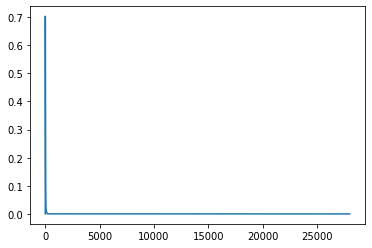

In [23]:
plt.plot(aux_loss_behaviour)
plt.show()

In [24]:
# Test the Model
correct = 0
total = 0
for star, labels in test_loader:
    images = Variable(star.view(-1, input_size)).cuda()
    outputs, _, _ = net(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted.cpu() == labels.long()).sum()
print('Accuracy of the network on test objects: %d %%' % (100 * correct / total))
acc_testing = 100 *correct / total
print(np.asarray(acc_testing))

Accuracy of the network on test objects: 81 %
81


In [25]:
correct = 0
total = 0
for star, labels in train_loader:
    images = Variable(star.view(-1, input_size)).cuda()
    outputs, _, _ = net(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted.cpu() == labels.long()).sum()
print('Accuracy of the network on train objects: %d %%' % (100 * correct / total))
acc_training = 100 *correct / total

Accuracy of the network on train objects: 99 %


In [26]:
# Save the Model
torch.save(net.state_dict(), 'model.pkl')

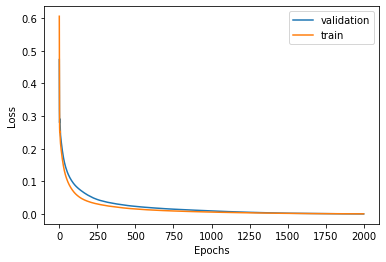

In [27]:
plt.plot(hist_val, label ='validation')
plt.plot(hist_train, label ='train')
plt.legend()
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.savefig('images/'+str(samples)+'_'+str(epsilon)+'_'+str(n)+"_"+str(hidden_size)+"_Loss_Training.png")
plt.show()

In [28]:
csv_file = open("size_MLP_noise.csv", "a")
csv_file.write(str(np.asarray(acc_testing))+","+str(np.asarray(acc_training))+","+str(samples)+","+str(epsilon)+","+str(n)+","+str(hidden_size)+"\n")
csv_file.close()

In [29]:
outputs, intermediates, intermediates2, labels = ut.get_representations(net, train_loader, device)
outputs_test, intermediates_test, intermediates2_test, labels_test = ut.get_representations(net, test_loader, device)

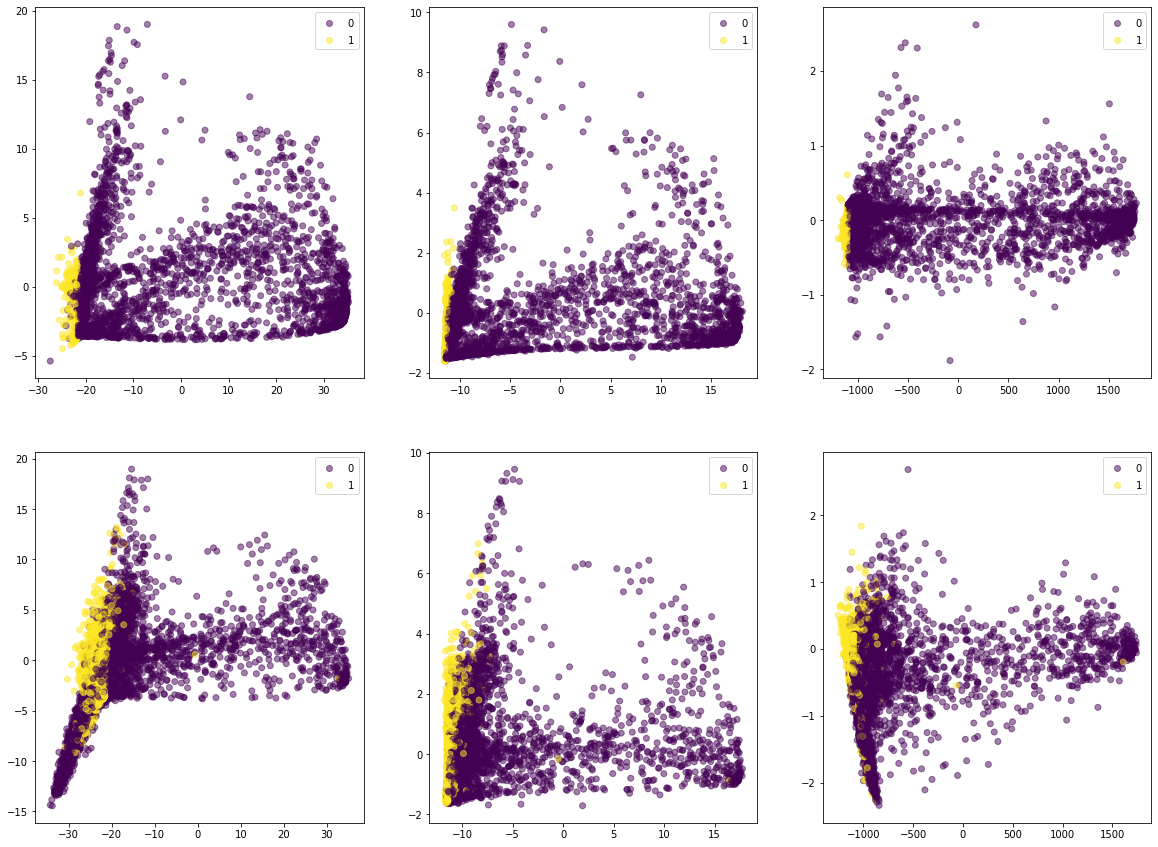

In [31]:
intermediate_pca_data, intermediate_pca_data_test = ut.get_pca(intermediates, data_test=intermediates_test)
fig, axs = plt.subplots(2, 3, figsize=(20,15))
ut.plot_representations(intermediate_pca_data, labels, axs[0, 0])
ut.plot_representations(intermediate_pca_data_test, labels_test, axs[1, 0])
intermediate2_pca_data, intermediate2_pca_data_test = ut.get_pca(intermediates2, data_test=intermediates2_test)
ut.plot_representations(intermediate2_pca_data, labels, axs[0, 1])
ut.plot_representations(intermediate2_pca_data_test, labels_test, axs[1, 1])
output_pca_data, output_pca_data_test = ut.get_pca(outputs, data_test=outputs_test)
ut.plot_representations(output_pca_data, labels, axs[0, 2])
ut.plot_representations(output_pca_data_test, labels_test, axs[1, 2])

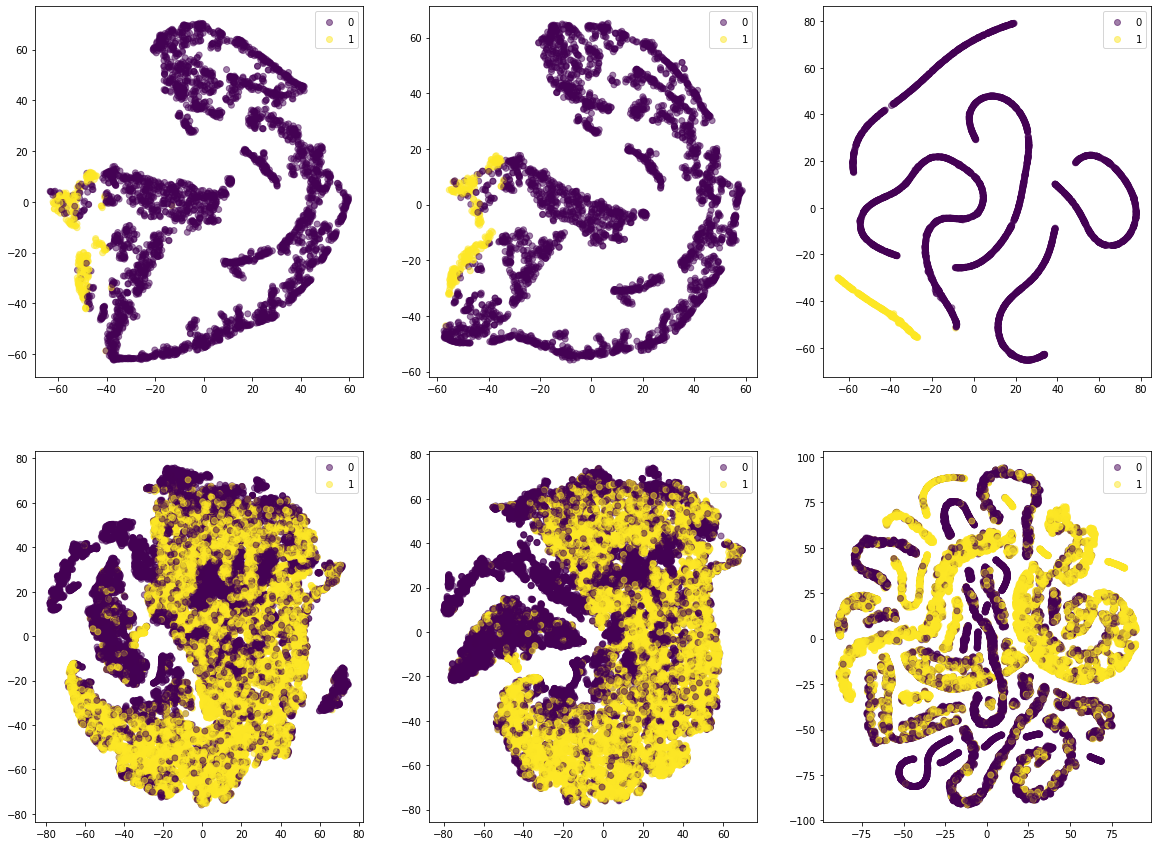

In [32]:
N_CURVES = 25000

fig, axs = plt.subplots(2, 3, figsize=(20,15))
intermediate_tsne_data, intermediate_tsne_data_test = ut.get_tsne(intermediates, data_test= intermediates_test, n_curves = N_CURVES)
ut.plot_representations(intermediate_tsne_data, labels, axs[0, 0],  n_curves = N_CURVES)
ut.plot_representations(intermediate_tsne_data_test, labels_test, axs[1, 0], n_curves = N_CURVES)

intermediate2_tsne_data, intermediate2_tsne_data_test = ut.get_tsne(intermediates2, data_test=intermediates2_test, n_curves = N_CURVES)
ut.plot_representations(intermediate2_tsne_data, labels, axs[0, 1], n_curves = N_CURVES)
ut.plot_representations(intermediate2_tsne_data_test, labels_test, axs[1, 1], n_curves = N_CURVES)

output_tsne_data, output2_tsne_data_test = ut.get_tsne(outputs, data_test=outputs_test, n_curves = N_CURVES)
ut.plot_representations(output_tsne_data, labels, axs[0, 2], n_curves = N_CURVES)
ut.plot_representations(output2_tsne_data_test, labels_test, axs[1, 2], n_curves = N_CURVES)

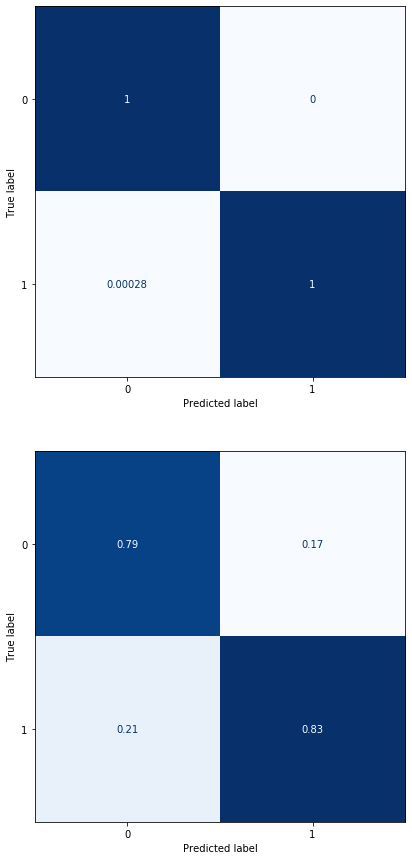

In [33]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15,15))
curves, labels, probs_train = ut.get_predictions(net, train_loader_pred, device)
pred_labels = probs_train.argmax(1, keepdim = True)
ut.plot_confusion_matrix(np.round(labels), pred_labels, ax1)
curves, labels, probs_test = ut.get_predictions(net, test_loader_pred, device)
pred_labels = probs_test.argmax(1, keepdim = True)
ut.plot_confusion_matrix(np.round(labels), pred_labels, ax2)

In [ ]:
print(len(train_tensor))
print(len(train_tensor_pred))

In [34]:
curves, labels, probs_train_sample = ut.get_predictions(net, train_loader, device)

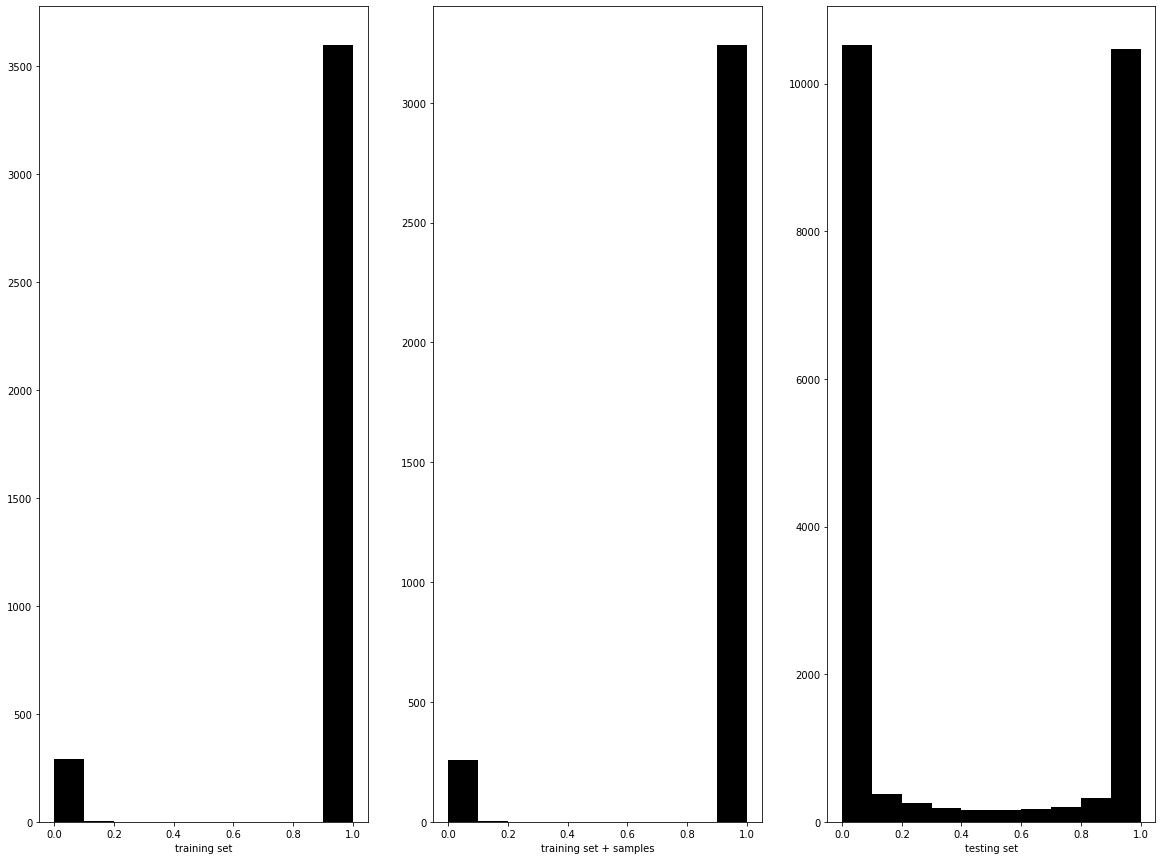

In [35]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,15))
ax1.hist(probs_train[:,0], color='black')
ax1.set_xlabel('training set')
ax2.hist(probs_train_sample[:,0], color='black')
ax2.set_xlabel('training set + samples')
ax3.hist(probs_test[:,0], color='black')
ax3.set_xlabel('testing set')
plt.show()

In [36]:
#N_WEIGHTS = 25
#weights = net.fc2.weight.data
#plot_weights(weights, N_WEIGHTS)

In [37]:
weights1 = net.fc1.weight.data
w1 = weights1.cpu().numpy().reshape(-1,1)
weights2 = net.fc2.weight.data
w2 = weights2.cpu().numpy().reshape(-1,1)
weights3 = net.fc3.weight.data
w3 = weights3.cpu().numpy().reshape(-1,1)

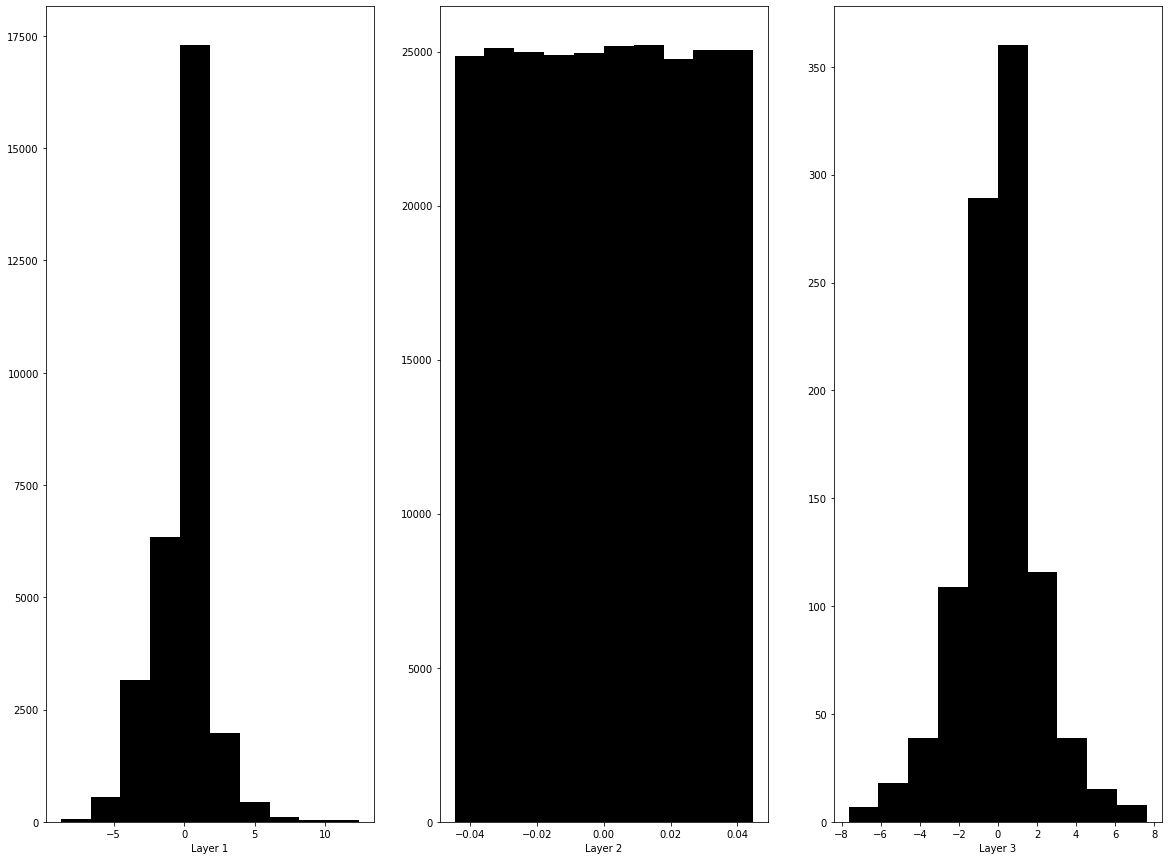

In [38]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,15))
ax1.hist(w1, color='black')
ax1.set_xlabel('Layer 1')
ax2.hist(w2, color='black')
ax2.set_xlabel('Layer 2')
ax3.hist(w3, color='black')
ax3.set_xlabel('Layer 3')
plt.show()